# RoboBrain 2.0 — Quick Test Notebook (Kaggle)

> Installs dependencies, pulls the GitHub repo, and runs sample inference for **general QA**, **visual grounding**, **affordance**, **trajectory**, and **pointing** tasks using the built-in examples.

**Notes**:
- This notebook defaults to the lighter `BAAI/RoboBrain2.0-3B` to fit Kaggle resources. Change to `7B` if you have a T4/P100 and enough VRAM.
- If you see CUDA OOM, switch `model_name` back to `3B`, set `device='cpu'`, or try `torch_dtype='float16'` on GPU.
- Internet is required to download the model from Hugging Face the first run.


## 1) Environment setup

In [1]:

# If you're on Kaggle, GPU is optional but recommended.
# You can check the GPU here:
!nvidia-smi || true

# Update pip and set fast HF download
%pip -q install --upgrade pip
%env HF_HUB_ENABLE_HF_TRANSFER=1

# Core deps (keep versions flexible for Kaggle images)
%pip -q install "transformers>=4.42.0" "accelerate>=0.30.0" "torch>=2.1.0" "timm>=0.9.16" pillow sentencepiece bitsandbytes --extra-index-url https://download.pytorch.org/whl/cu118 || true

# Clone RoboBrain2.0 repo
import os, shutil, subprocess, sys, pathlib
repo_url = "https://github.com/FlagOpen/RoboBrain2.0.git"
repo_dir = "/kaggle/working/RoboBrain2.0"
if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)
!git clone -q {repo_url} {repo_dir}

# Install any extra requirements from the repo (best-effort)
req = pathlib.Path(repo_dir) / "requirements.txt"
if req.exists():
    !pip -q install -r {req} || true


Mon Sep  8 12:21:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2) Import helper and configure model

In [9]:
# === RoboBrain 2.0 loader (Kaggle secrets + token verification + gated check) ===
import os, sys, torch, traceback, pathlib

REPO = "/kaggle/working/RoboBrain2.0"
sys.path.insert(0, REPO)

# -- 1) Get HF token properly on Kaggle
token = None
try:
    from kaggle_secrets import UserSecretsClient
    usc = UserSecretsClient()
    token = usc.get_secret("HF_TOKEN")  # Add-Ons → Secrets → create HF_TOKEN
except Exception:
    # fallback if you manually export it
    token = os.environ.get("HF_TOKEN")

if not token:
    raise SystemExit(
        "HF_TOKEN not found. In Kaggle: Add-Ons → Secrets → Add new secret named HF_TOKEN "
        "with your Hugging Face *user* access token (starts with 'hf_')."
    )

token = token.strip().strip('"').strip("'")
if not token.startswith("hf_"):
    raise SystemExit("Your HF token looks invalid. It must start with 'hf_'. Generate a *user* token with Read access.")

# -- 2) Verify token & gated repo access before loading
from huggingface_hub import HfApi, login
from huggingface_hub.utils import GatedRepoError, RepositoryNotFoundError, HfHubHTTPError

api = HfApi()
try:
    me = api.whoami(token=token)
    print(f"✅ HF token OK. Logged in as: {me.get('name') or me.get('user',{}).get('username')}")
except HfHubHTTPError as e:
    raise SystemExit(f"HF token rejected (whoami 401). Recreate a user token and try again.\nDetails: {e}")

model_name = os.environ.get("ROBOBRAIN_MODEL", "BAAI/RoboBrain2.0-3B")

# Check you actually have access to the gated model repo
try:
    _ = api.model_info(model_name, token=token)
    print(f"✅ Access to gated repo confirmed: {model_name}")
except GatedRepoError:
    raise SystemExit(
        f"You have not accepted access for {model_name}. Visit its HF page while logged in and click 'Agree/Access', "
        "then re-run the cell."
    )
except RepositoryNotFoundError:
    raise SystemExit(f"Model repo not found: {model_name}. Double-check the name.")
except Exception as e:
    print("⚠️ Could not confirm model access:", repr(e))
    print("Continuing, but model load may still fail…")

# Actually log in so transformers/accelerate can use the token
login(token=token)

# -- 3) Device selection and model load with friendlier errors
force_cpu = os.environ.get("FORCE_CPU", "0") == "1"
device = "cuda" if (torch.cuda.is_available() and not force_cpu) else "cpu"
print(f"Using device: {device} — model: {model_name}")

from inference import UnifiedInference
try:
    print("Loading Checkpoint ...")
    model = UnifiedInference(model_name)  # uses HF token session under the hood
    print("✅ Model loaded.")
except Exception as e:
    traceback.print_exc()
    raise SystemExit(
        "\nModel load failed.\n"
        "Checklist:\n"
        " • You clicked 'Agree/Access' on the model page while logged in.\n"
        " • Token is a *user* token (not org), has at least Read permission.\n"
        " • If CUDA OOM, set FORCE_CPU=1 or stay on the 3B checkpoint.\n"
        " • Re-run the cell to retry the first-time large download."
    )

✅ HF token OK. Logged in as: YasiruDEX
✅ Access to gated repo confirmed: BAAI/RoboBrain2.0-3B
Using device: cuda — model: BAAI/RoboBrain2.0-3B
Loading Checkpoint ...
Loading Checkpoint ...


config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Model thinking support: False
✅ Model loaded.


## 3) General image QA (with and without 'thinking')

In [10]:

from pprint import pprint

prompt = "What is shown in this image?"
image = "http://images.cocodataset.org/val2017/000000039769.jpg"

pred_no_thinking = model.inference(prompt, image, task="general", enable_thinking=False, do_sample=True)
pred_thinking = model.inference(prompt, image, task="general", enable_thinking=True, do_sample=True)

print("=== General (no thinking) ===")
pprint(pred_no_thinking)
print("\n=== General (with thinking) ===")
pprint(pred_thinking)



==================== INPUT ====================
What is shown in this image?

Running inference ...

==================== INPUT ====================
What is shown in this image?

Running inference ...
=== General (no thinking) ===
{'answer': 'The image shows two cats sleeping on a couch, next to each other.'}

=== General (with thinking) ===
{'answer': 'The image shows two cats sleeping on a couch, likely on a pink '
           'blanket.'}


## 4) Visual Grounding

Grounding task detected. Adding grounding prompt.

==================== INPUT ====================
Please provide the bounding box coordinate of the region this sentence describes: the person wearing a red hat.

Running inference ...
=== Grounding ===
{'answer': '[0, 194, 267, 632]'}


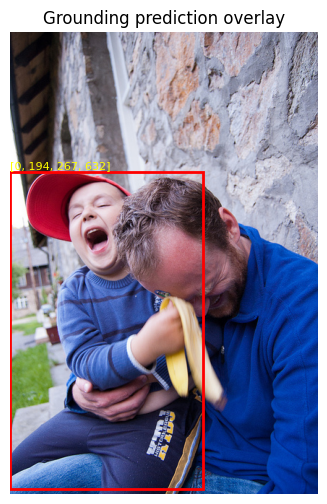

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import ast

# Demo asset
img_path = f"{REPO}/assets/demo/grounding.jpg"
prompt = "the person wearing a red hat"

# Run inference
pred = model.inference(prompt, img_path, task="grounding", enable_thinking=True, do_sample=True)
print("=== Grounding ===")
print(pred)

# --- Visualization ---
im = Image.open(img_path)
plt.figure(figsize=(8,6))
plt.imshow(im)

# Parse bounding box
try:
    bbox = ast.literal_eval(pred["answer"])
except Exception:
    bbox = []

if bbox and len(bbox) == 4:
    x1, y1, x2, y2 = bbox
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=2, edgecolor="red", facecolor="none")
    plt.gca().add_patch(rect)
    plt.text(x1, y1-5, f"{bbox}", color="yellow", fontsize=8)

plt.axis("off")
plt.title("Grounding prediction overlay")
plt.show()

## 5) Affordance

Affordance task detected. Adding affordance prompt.

==================== INPUT ====================
You are a robot using the joint control. The task is "hold the cup". Please predict a possible affordance area of the end effector.

Running inference ...
=== Affordance ===
{'answer': '[561, 205, 613, 284]'}


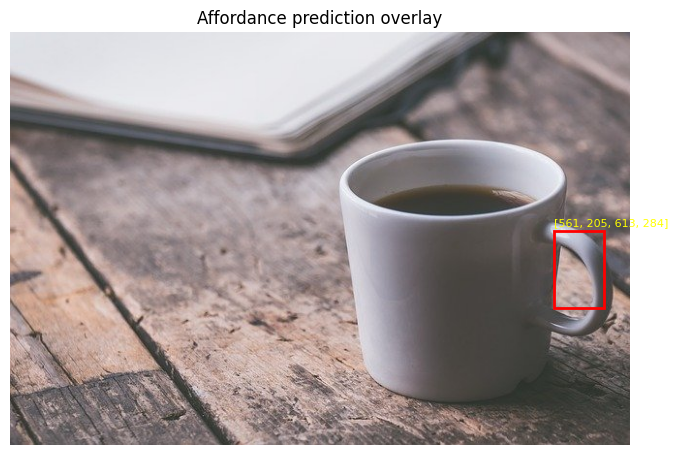

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import ast

img_path = f"{REPO}/assets/demo/affordance.jpg"
prompt = "hold the cup"

# Run inference
pred = model.inference(prompt, img_path, task="affordance", enable_thinking=True, do_sample=True)
print("=== Affordance ===")
print(pred)

# --- Visualization ---
im = Image.open(img_path)
plt.figure(figsize=(8,6))
plt.imshow(im)

# Parse bounding box from prediction
try:
    bbox = ast.literal_eval(pred["answer"])
except Exception:
    bbox = []

if bbox and len(bbox) == 4:
    x1, y1, x2, y2 = bbox
    # Draw rectangle
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=2, edgecolor="red", facecolor="none")
    plt.gca().add_patch(rect)
    plt.text(x1, y1-5, f"{bbox}", color="yellow", fontsize=8)

plt.axis("off")
plt.title("Affordance prediction overlay")
plt.show()

## 6) Trajectory

Trajectory task detected. Adding trajectory prompt.

==================== INPUT ====================
You are a robot using the joint control. The task is "reach for the banana on the plate". Please predict up to 10 key trajectory points to complete the task. Your answer should be formatted as a list of tuples, i.e. [[x1, y1], [x2, y2], ...], where each tuple contains the x and y coordinates of a point.

Running inference ...
=== Trajectory ===
{'answer': '[(145, 123), (176, 120), (198, 78), (224, 74)]'}


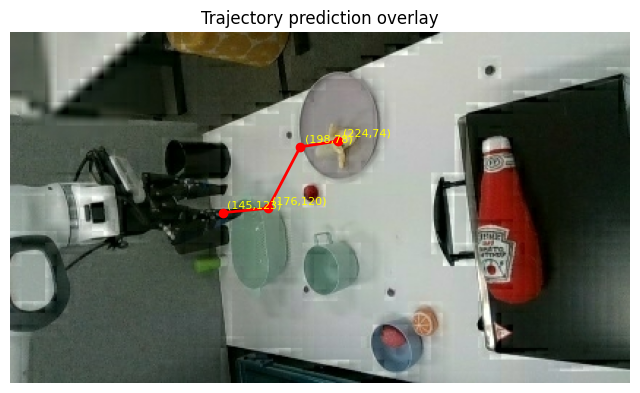

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img_path = f"{REPO}/assets/demo/trajectory.jpg"
prompt = "reach for the banana on the plate"

# Run inference
pred = model.inference(prompt, img_path, task="trajectory", enable_thinking=True, do_sample=True)
print("=== Trajectory ===")
print(pred)

# --- Visualization ---
# Load image
im = Image.open(img_path)
plt.figure(figsize=(8,6))
plt.imshow(im)

# Parse trajectory points from pred['answer']
# (They come as a string like '[(137, 116), (169, 94), ...]')
import ast
try:
    points = ast.literal_eval(pred["answer"])
except Exception:
    points = []

if points:
    xs, ys = zip(*points)
    # Draw line and markers
    plt.plot(xs, ys, marker='o', color='red', linewidth=2, markersize=6)
    for (x, y) in points:
        plt.text(x+3, y-3, f"({x},{y})", color="yellow", fontsize=8)

plt.axis("off")
plt.title("Trajectory prediction overlay")
plt.show()

## 7) Pointing

Pointing task detected. Adding pointing prompt.

==================== INPUT ====================
Identify several spots within the vacant space that's between the two mugs. Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should indicate the normalized pixel locations of the points in the image.

Running inference ...
=== Pointing ===
{'answer': '[(376, 345), (369, 359), (380, 369), (362, 400), (366, 387), (328, 379), (376, 389), (353, 387), (352, 376), (348, 403)]'}


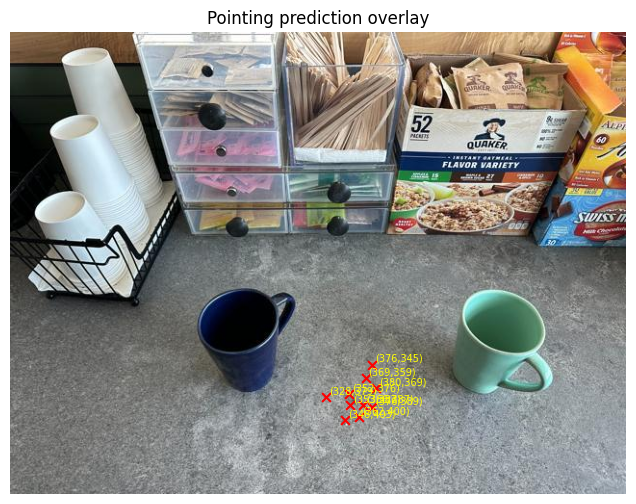

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import ast

img_path = f"{REPO}/assets/demo/pointing.jpg"
prompt = "Identify several spots within the vacant space that's between the two mugs"

# Run inference
pred = model.inference(prompt, img_path, task="pointing", enable_thinking=True, do_sample=True)
print("=== Pointing ===")
print(pred)

# --- Visualization ---
im = Image.open(img_path)
plt.figure(figsize=(8,6))
plt.imshow(im)

# Parse coordinates from prediction
try:
    points = ast.literal_eval(pred["answer"])
except Exception:
    points = []

# Plot each point
if points:
    xs, ys = zip(*points)
    plt.scatter(xs, ys, c="red", s=40, marker="x")
    for (x, y) in points:
        plt.text(x+3, y-3, f"({x},{y})", color="yellow", fontsize=7)

plt.axis("off")
plt.title("Pointing prediction overlay")
plt.show()

## 8) Save lightweight results summary

In [15]:

results = {
    "general_no_thinking": pred_no_thinking,
    "general_with_thinking": pred_thinking,
}
import json, pathlib
out_path = pathlib.Path("/kaggle/working/robobrain2_results.json")
with open(out_path, "w") as f:
    json.dump(results, f, indent=2)
print("Saved:", out_path)


Saved: /kaggle/working/robobrain2_results.json
